# Importing Packages:

In [1]:
import matplotlib.pyplot as plt #for plotting and viewing images
%matplotlib inline
import matplotlib.patches as patches # creating the bounding box
from PIL import Image #pulling image from file
import pandas as pd #for creating a dataframe to view our info
import numpy as np
import os
import xml.etree.ElementTree as ET # creating tree from annotations file and iterating over them

# Creating Image Dataframe:

In [2]:
# creating path variables to our image and annotation data

img_path = "Data/images"
ann_path = "Data/annotations"

In [3]:
# creating function to create a list of data files

def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [4]:
# creating another function that iterates over file list while creating a dict of key:value pairs from xml data in each file

def get_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml') #building list of xml files
    info_list = []              #empty list to store dicts
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['im'] = os.path.join(str(img_path) + '/'+ root.find("./filename").text) #image file
        ann['width'] = root.find("./size/width").text           #image size
        ann['height'] = root.find("./size/height").text
        ann['class'] = root.find("./object/name").text          #image category
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)     #bounding box xy coordinates  
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        info_list.append(ann)
    return pd.DataFrame(info_list)

In [5]:
df = get_df(ann_path, img_path)    # Creating Dataframe

In [6]:
df.head()    # Did we produce what we expected?

im width height         class  xmin  ymin  xmax  ymax
0    Data/images/road0.png   267    400  trafficlight    98    62   208   232
1    Data/images/road1.png   400    283  trafficlight   154    63   258   281
2   Data/images/road10.png   400    267  trafficlight   106     3   244   263
3  Data/images/road100.png   400    385    speedlimit    35     5   363   326
4  Data/images/road101.png   400    200    speedlimit   195     7   392   194

In [7]:
df.shape     # How much data do we have? 

(877, 8)

# Image Dataframe EDA:

In [8]:
# Separating the data by sign class to see how many of each we have

light_df = df[df['class'] == 'trafficlight'].reset_index(drop=True)
speed_df = df[df['class'] == 'speedlimit'].reset_index(drop=True)
crosswalk_df = df[df['class'] == 'crosswalk'].reset_index(drop=True)
stop_df = df[df['class'] == 'stop'].reset_index(drop=True)

In [9]:
print(f'images grouped in traffic light class: {len(light_df)}')    # Class sizes
print(f'images grouped in speed limit class: {len(speed_df)}')
print(f'images grouped in crosswalk class: {len(crosswalk_df)}')
print(f'images grouped in stop class: {len(stop_df)}')

images grouped in traffic light class: 61
images grouped in speed limit class: 652
images grouped in crosswalk class: 88
images grouped in stop class: 76


### _Class sizes let us see how many examples of each class we will have for our model. Three of the four classes have small numbers, so our model may need to loop over our training data several times to find the best fit for prediction._

In [10]:
# creating a function to take each df and plot the bounding box over our images while showing images in subplots

def show_dfandBB(df,figsize):
    fig,ax = plt.subplots(int((len(df)/5)+1),5, figsize=figsize)   # will have to adjust figsize as needed once 
    for i in range(len(df)):                                       # we've seen results. image size will vary by # of images
        im = Image.open(df.loc[i,'im'])
        BB = patches.Rectangle((df.loc[i,'xmin'],df.loc[i,'ymin']), (df.iloc[i,6] - df.iloc[i,4]), \
                           (df.iloc[i,7] - df.iloc[i,5]),linewidth=2, edgecolor='r', facecolor='none' )
        ax[i//5,i%5].imshow(im)     # finding the next axes for current plot. when using 5 columns
        ax[i//5,i%5].add_patch(BB)  # adding bounding box to image
    plt.show()

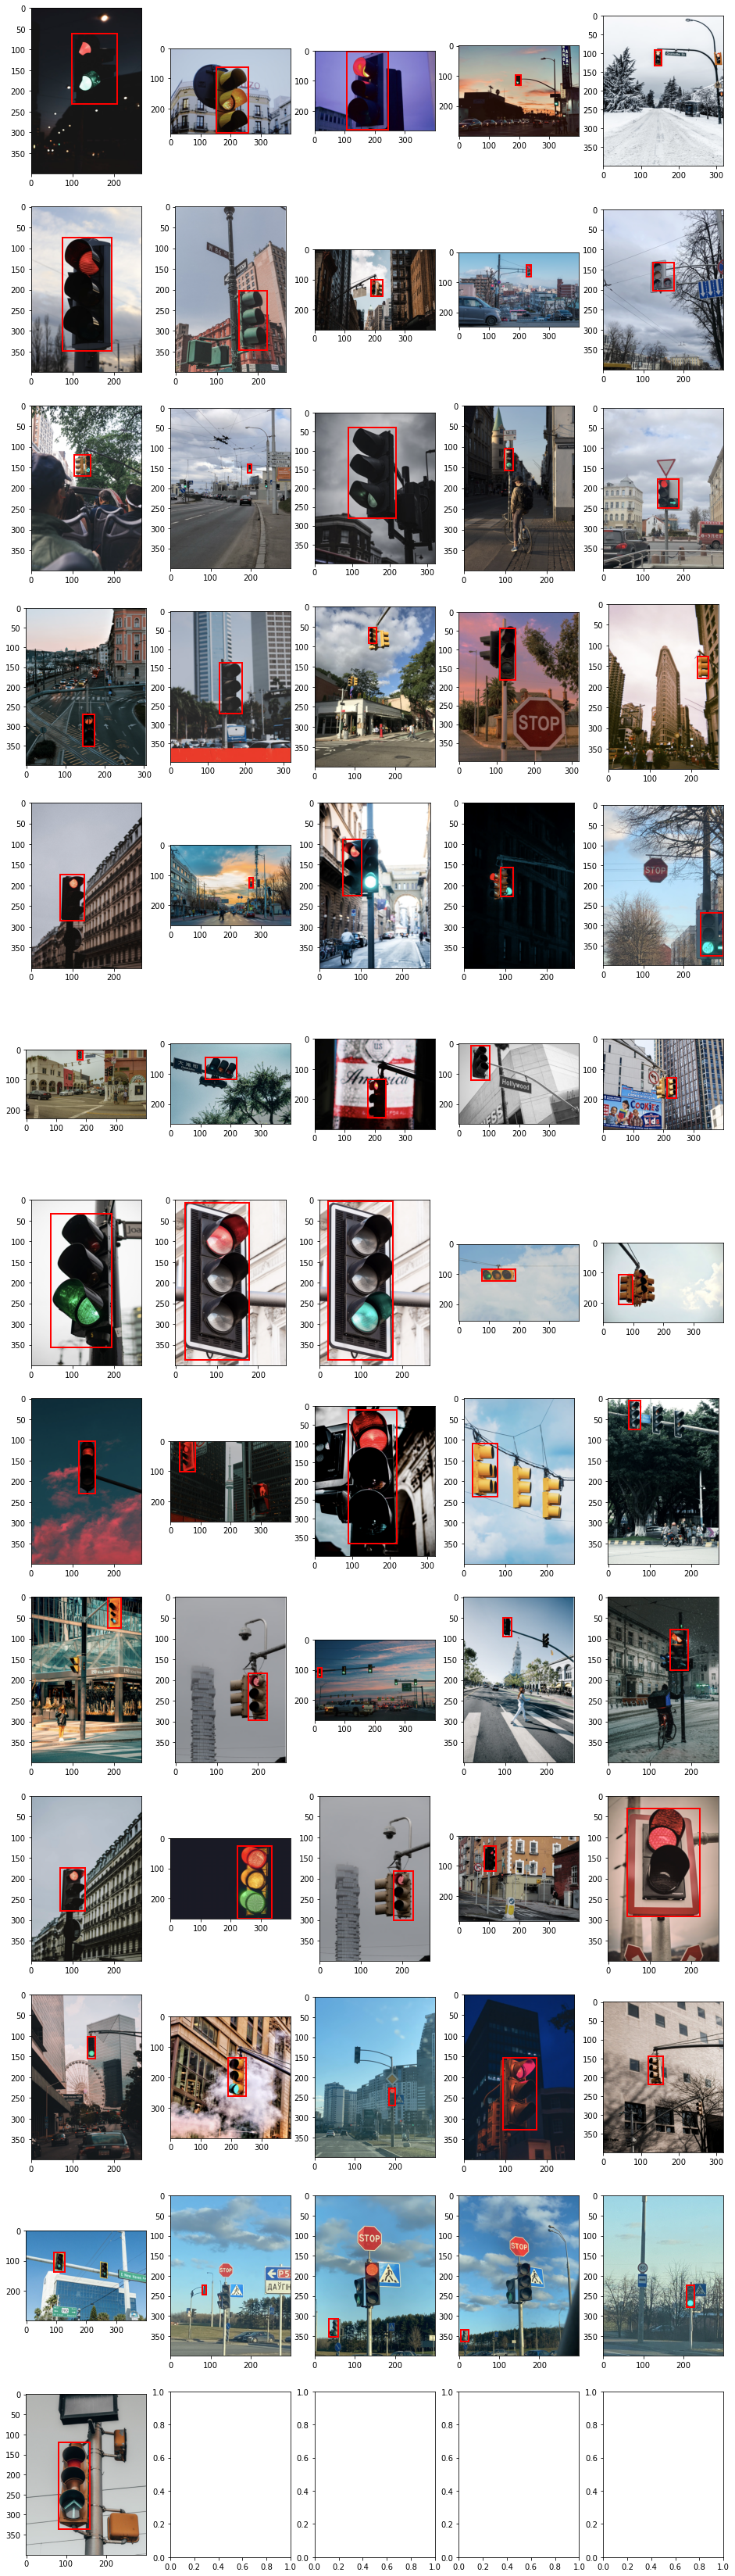

In [11]:
show_dfandBB(light_df,(16,60))  # getting a look at our traffic light data

### Two glaring issues we have after our first look over traffic light data:

* issue 1
    * We have multiple traffic lights in some images while only one oject per image gets a bounding box
* issue 2
    * We have images where there are multiple classes pictured, but our image is labeled with the class within our bounding box

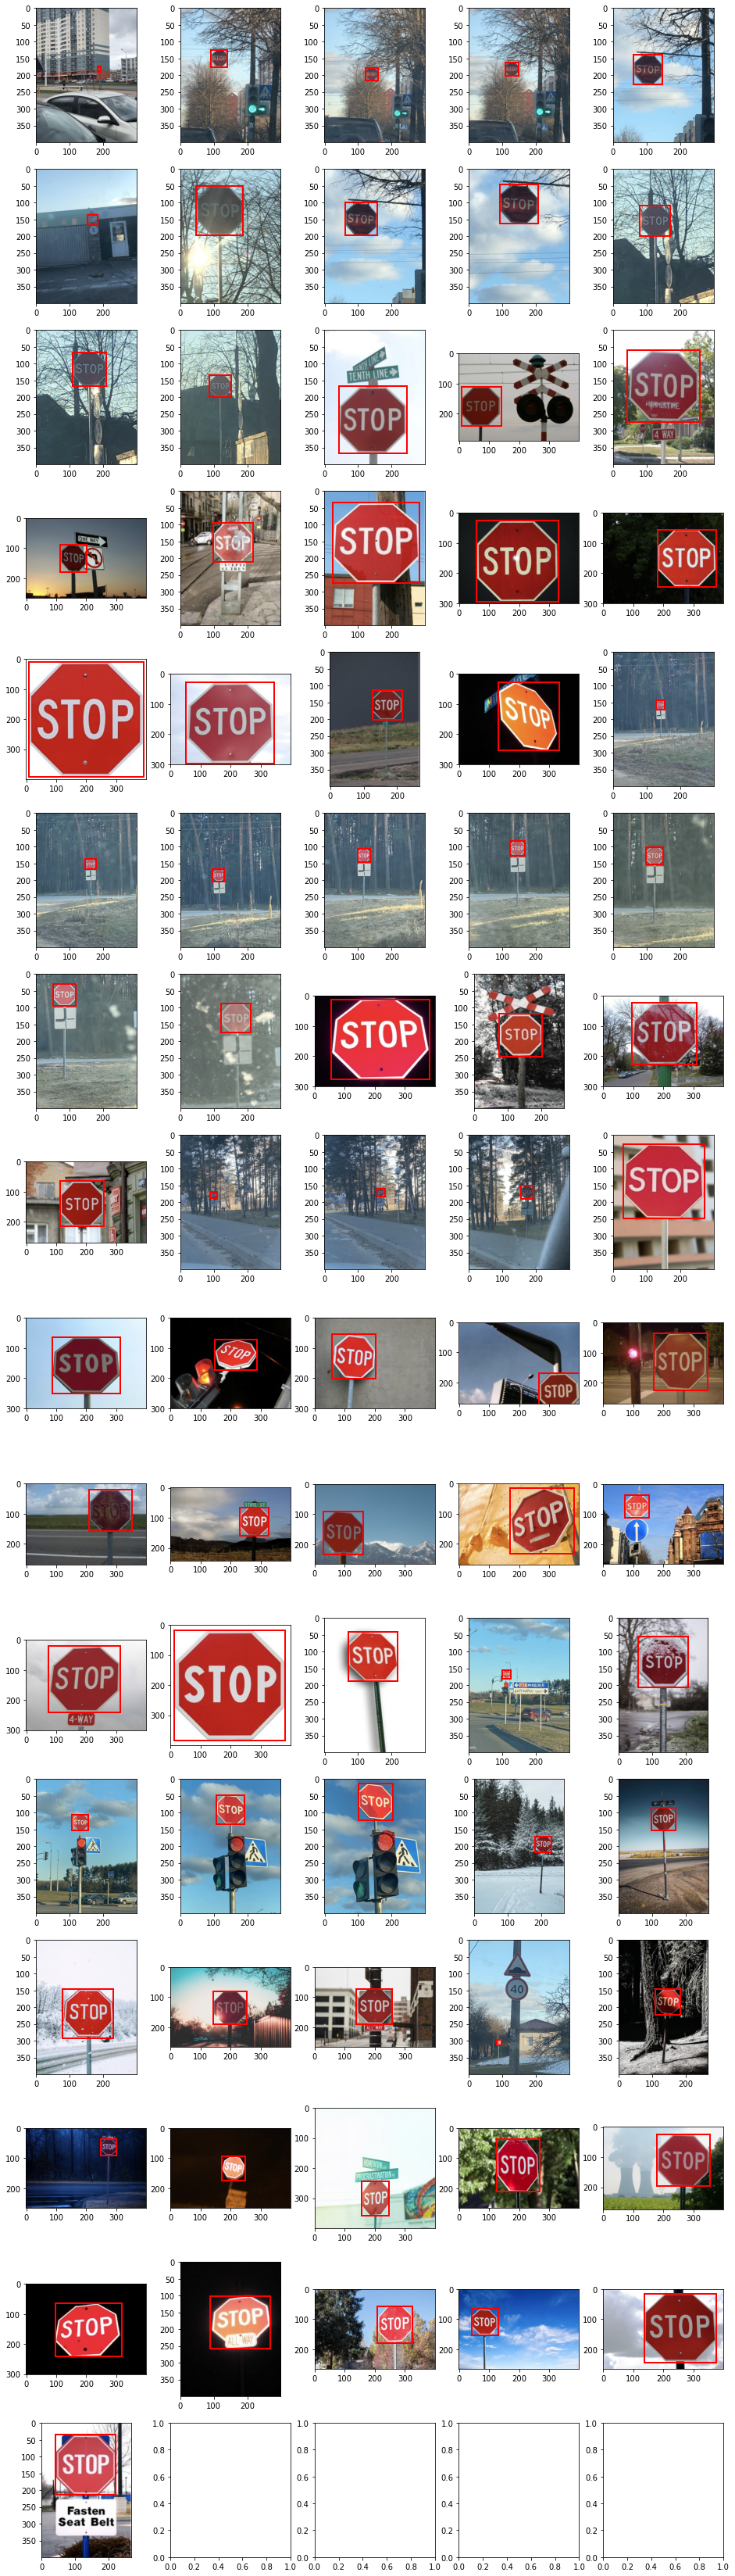

In [12]:
show_dfandBB(stop_df,(16,60))  # Stop sign df

### The same issues can be seen in our stop sign data, so we can assume all our image classes will have at least some images that contain signs of a different class from the one labeled and may contain multiple signs of the same class

In [13]:
# seeing how many different widths and heights we have from our image data to identify a good size that could fit all data well

print(f"# of different widths: {df.width.nunique()},   min value: {df.width.min()},   max value: {df.width.max()},\
  avg value:{round(df.width.astype('int').mean())}")
print(f"# of different heights: {df.height.nunique()},   min value: {df.height.min()},   max value: {df.height.max()},\
  avg value:{round(df.height.astype('int').mean())}")

# of different widths: 11,   min value: 254,   max value: 400,  avg value:310
# of different heights: 36,   min value: 166,   max value: 400,  avg value:386


### _Our images are of several sizes in width and height. We may have to adjust this by resizing, but being careful  not to distort the image beyond what is needed. We could also try padding with some of our models and see if any difference is seen in our predictions_

##### I think we can proceed to the next step of processing our images and data for our models. As we will be using neural network models to learn and predict on our data, our next steps will be splitting into training, testing, and validation sets. Our pixel values may need to be normalized, and a uniform image size for the dataset may be needed. All this will be completed in the following notebook.